In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import ray

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

import lina

pupil_diam = 6.75*u.mm 
lyot_diam = 3.6*u.mm
det_rotation = -5 #  degrees of rotation of the detector relative to the optical axis

# The flattest wavefront obtained for the system in the lab by
# performing phase diversity
dm_flat = fits.getdata(scoob.module_path/'scoob_dm_flat.fits')

wavelength_c = 632.8e-9*u.m # central wavelength

nlam = 3
bandwidth = 10/wavelength_c.to_value(u.nm)
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )
print(wavelengths)

npix = 512
oversample = 8

vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)

[6.278e-07 6.328e-07 6.378e-07] m


# Create actors

In [11]:
raySCOOB = ray.remote(scoobpsf.scoob.SCOOBM) # make a ray actor class from the original CGI class  

kwargs = {
    'npsf':150,
    'use_synthetic_opds':True,
    'pupil_diam':pupil_diam,
    'det_rotation':det_rotation,
}

actors = []
for i in range(nlam):
    actors.append(raySCOOB.options(num_cpus=2, num_gpus=1/8).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])

ParallelizedScoob Initialized!


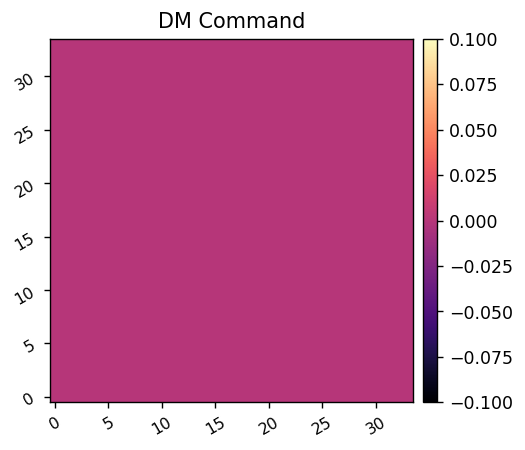

NameError: name 'snaps' is not defined

In [21]:
reload(scoobpsf.parascoob)
model = scoobpsf.parascoob.ParallelizedScoob(actors)
model.show_dm()

im0 = model.snap()

In [ ]:
reload(parascoob)
model = parascoob.ParallelizedScoob()
model.show_dm()

im0 = model.snap()
model.Imax_ref = im0.max()

ref_unocc_im = model.snap(plot=True)

model.FPM = vortex
model.LYOT = lyot_stop

ref_im = model.snap(plot=True)